## Computer Vision and Convolutional Neural Networks - PyTorch



### 0. Computer Vision Libraries in PyTorch

* `torchvision` - base domain library for PyTorch computer vision
* `torchvision.datasets` - get datasets and dataloading functions for computer vision here
* `torchvision.models` - get pretrained computer vision models that can leverage for your own problems
* `torch.utils.data.Dataset` - Base dataset class for PyTorch.
* `torch.utils.data.DataLoader` - Creates a Python Iterable over a dataset

In [162]:
# Import PyTorch
import torch
import torch.nn as nn

# Import torchvision 
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualisation
import matplotlib.pyplot as plt

# Check Versions
print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu118
0.15.2+cu118


### 1. Getting a Dataset

The dataset we'll be using is FashionMNIST.

In [163]:
# Setup training data
train_data = datasets.FashionMNIST(
    root='data',
    train= True,
    download=True,
    transform= ToTensor(),  # How do we want to transform the data 
    target_transform=None  # How do we want to transform the test labels/targets?
)


#Setup test data
test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)


In [164]:
test_data.targets.unique() # Here we can see that there are 9 unique categories

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [165]:
train_data.data.shape, test_data.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [166]:
test_data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

Image shape: torch.Size([1, 28, 28])


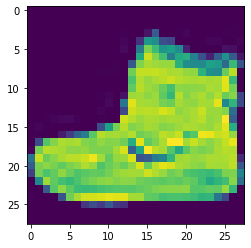

In [167]:
image,label = train_data[0]
print(f'Image shape: {image.shape}')
plt.imshow(image.squeeze())
plt.show()

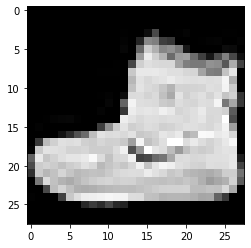

In [168]:
plt.imshow(image.squeeze(),cmap='gray')
plt.show()

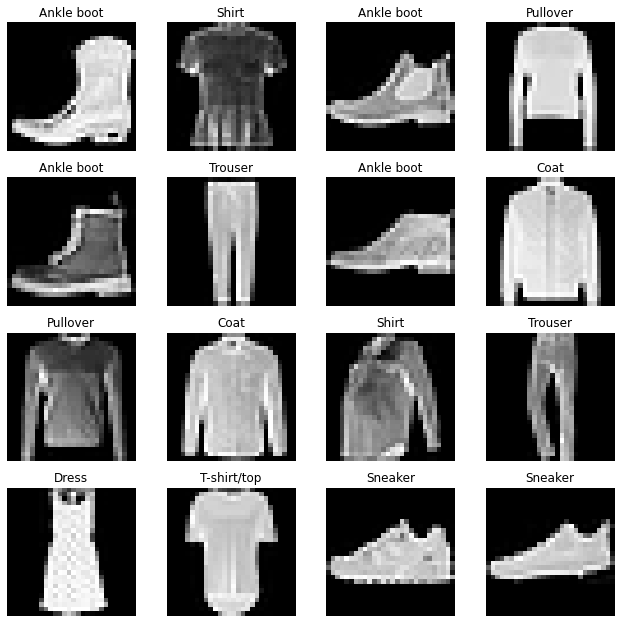

In [169]:
#Let us print out 16 images and their labels
plt.figure(figsize=(9,9))

for i in range(1,17):
    idx = torch.randint(0,len(train_data),size=(1,))
    img,lbl = train_data[idx.item()]
    plt.subplot(4,4,i)
    plt.imshow(img.squeeze(),cmap='gray')
    plt.tight_layout()
    plt.axis(False)
    plt.title(train_data.classes[lbl])


### 2. Prepare DataLoader 

Right now, our data is in the form of PyTorch Datasets. 

DataLoader turns our dataset into a Python Iterable.

More specifically, we want to turn our data into batches (or mini-batches)

Why would we do this?

1. It is more computationally efficient, as in, your computing hardware may not be able to look (store in memory) at 60000 images in one hit. So we break it down to 32 images at a time (batch size of 32)

2. It gives our neural network more chances to update its gradients per epoch.

In [170]:
from torch.utils.data import DataLoader

In [172]:
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=32,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=32,
    shuffle=False
)

# Lets check out what we've created 

print(f'DataLoaders: {train_dataloader,test_dataloader}')

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x000002359B505BA0>, <torch.utils.data.dataloader.DataLoader object at 0x000002359B5A72B0>)


In [173]:
len(train_dataloader), len(test_dataloader)

(1875, 313)

In [174]:
# Check out what's inside our dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [175]:
for batch, (X, y) in enumerate(train_dataloader):
    if(batch%400==0):
        print(f'Batch: {batch} | X Shape: {len(X)} | Y len: {len(y)}')

Batch: 0 | X Shape: 32 | Y len: 32
Batch: 400 | X Shape: 32 | Y len: 32
Batch: 800 | X Shape: 32 | Y len: 32
Batch: 1200 | X Shape: 32 | Y len: 32
Batch: 1600 | X Shape: 32 | Y len: 32


In [176]:
len(train_features_batch)

32

In [177]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0,len(train_features_batch),(1,)).item()
img,label = train_features_batch[random_idx], train_labels_batch[random_idx]

Text(0.5, 1.0, 'Trouser')

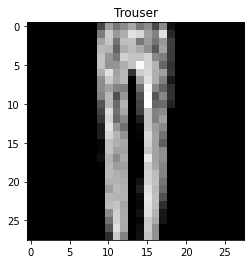

In [178]:
plt.imshow(img.squeeze(),cmap='gray')
plt.title(train_data.classes[label])

### 3. Model 0: Build a Baseline Model

When starting to build a series of machine learning modelling experiments, it's best practice to start with a baseline model.

A baseline model is a simple model you will try and improve upon with subsequent models/experiments.

In other words: start simply and add complexity when necessary.

In [179]:
# Create a flatter layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

x.shape  # Shape before flattening

torch.Size([1, 28, 28])

In [180]:
output = flatten_model(x)

output.shape # Shape after flattening 

torch.Size([1, 784])

In [181]:
# Define the Computer Vision Model Class

class FashionMNISTModelV0(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape,hidden_units),
            nn.Linear(hidden_units,output_shape)
        )


    def forward(self, x):
        return self.layer_stack(x)

In [182]:
torch.manual_seed(42)

# Setup model with input parameters
model_0 = FashionMNISTModelV0(784,10,10)

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [183]:
dummy_x = torch.rand([1,1,28,28])

model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

#### 3.1 Setup loss, optimizer and evaluation metrics

* Loss function - since we're working with multi-class data, our loss function will be `nn.CrossEntropyLoss()`
* Optimizer - we will continue to use the `torch.optim.SGD()` optimizer 
* Evaluation Metric - We are going to use accuracy to evaluate the model because it is a multiclass classifcation problem. 

In [184]:
# Import accuracy metric 
from helper_functions import accuracy_fn

# Setup loss function and optimizer 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(),lr = 0.05)


#### 3.2 Creating a function to time our experiments

Machine Learning is very experimental. 

Two of the main things you'll often want to track are:
1. Model's Performance (loss and accuracy values etc.)
2. How fast it runs

In [185]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    total_time = end - start
    print(f'Train time on {device}: {total_time:.3f} seconds')
    return total_time*1000

#### 3.3 Creating a training loop and training a model on batches of data

1. Loop through epochs. 
2. Loop through training batches, perform training steps, calculate the train loss *per batch*.
3. Loop through testing batches, perorm testing steps, calculate the test loss *per batch*.
4. Print out what's happening 
5. Time it all (for fun).

In [186]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training time)
epochs = 3

# Creating training and test loop
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n-----')
    ### Training
    train_loss = 0
    # Add a loop to loop through the training batches
    for batch, (X,y) in enumerate(train_dataloader):
        model_0.train()
        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred,y)
        train_loss +=loss # Accumulate train loss

        # 3. Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print out what's happening
        if batch % 400 == 0:
            print(f'Looked at {batch*len(X)} /{ len(train_dataloader.dataset)} samples.')
    
    train_loss /= len(train_dataloader)

### Testing loop
test_loss, test_acc = 0,0
model_0.eval()
with torch.inference_mode():
    for X_test,y_test in test_dataloader:
        # 1. Forward pass
        test_pred = model_0(X_test)

        # 2. Calculate loss (accumulatively)
        test_loss += loss_fn(test_pred,y_test)

        # 3. Calculate accuracy 
        test_acc += accuracy_fn(y_true=y_test,y_pred = test_pred.argmax(dim=1))

    # Calculate the test loss average per batch test_loss /= len(test_dataloader)
    test_loss /= len(test_dataloader)

    # Calculate the test acc average per batch
    test_acc /= len(test_dataloader)

# Print out what's happening
print(f'\n Train loss: {train_loss:.4f}  | Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}')

#Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(train_time_start_on_cpu,train_time_end_on_cpu,device='cpu')


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-----
Looked at 0 /60000 samples.
Looked at 12800 /60000 samples.
Looked at 25600 /60000 samples.
Looked at 38400 /60000 samples.
Looked at 51200 /60000 samples.
Epoch: 1
-----
Looked at 0 /60000 samples.
Looked at 12800 /60000 samples.
Looked at 25600 /60000 samples.
Looked at 38400 /60000 samples.
Looked at 51200 /60000 samples.
Epoch: 2
-----
Looked at 0 /60000 samples.
Looked at 12800 /60000 samples.
Looked at 25600 /60000 samples.
Looked at 38400 /60000 samples.
Looked at 51200 /60000 samples.

 Train loss: 0.4493  | Test loss: 0.5036 | Test accuracy: 82.4081
Train time on cpu: 19.421 seconds


### 4. Make Predictions and get Model 0 Results

In [187]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    loss,acc = 0,0
    model.eval()
    with torch.inference_mode():
        for X,y in data_loader:
            # Make predictions 
            y_pred = model(X)

            # Accumulate the loss and acc values per batch
            loss  += loss_fn(y_pred,y)
            acc += accuracy_fn(y_true=y,
                               y_pred = y_pred.argmax(dim=1))
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_0" : model.__class__.__name__ ,
            "model_loss" : loss.item(),
            "model_acc" : acc}

# Calculate model 0 results on test dataset
eval_model(model_0,test_dataloader,loss_fn,accuracy_fn)


{'model_0': 'FashionMNISTModelV0',
 'model_loss': 0.5035960674285889,
 'model_acc': 82.40814696485623}

### 5. Setup device agnostic-code (for using a GPU if there is one)

In [58]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### 6. Improving through Experimentation 

Trying to introduce non-linearities into our model


In [77]:
# Define the CNN Model Class

class FashionMNISTModelV1(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape,hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units,output_shape),
            nn.ReLU()
        )


    def forward(self, x):
        return self.layer_stack(x)

In [128]:
model_1 = FashionMNISTModelV1(784,10,10).to('cpu')


In [101]:
model_1

FashionMNISTModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [127]:
# Import accuracy metric 
from helper_functions import accuracy_fn

# Setup loss function and optimizer 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(),lr = 0.1)

In [103]:
y_pred = model_1(dummy_x)

y_pred

tensor([[0.1079, 0.0816, 0.1550, 0.0000, 0.0000, 0.1201, 0.0000, 0.0000, 0.0000,
         0.0000]], grad_fn=<ReluBackward0>)

In [117]:
(X_dummy, y_dummy) = next(iter(train_dataloader))

dummy_pred = model_1(X_dummy)

dummy_pred[0] , y_dummy[0]

(tensor([ 3.7462, 18.6128,  0.0000,  5.8148,  4.9201,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000], grad_fn=<SelectBackward0>),
 tensor(1))

In [118]:
loss = loss_fn(dummy_pred,y_dummy)

In [122]:
torch.argmax(dummy_pred,dim=1)

tensor([1, 4, 0, 3, 0, 9, 1, 5, 0, 0, 8, 5, 1, 0, 3, 9, 0, 2, 0, 4, 2, 5, 3, 2,
        5, 0, 9, 3, 0, 1, 4, 1])

In [123]:
y_dummy

tensor([1, 4, 0, 3, 0, 9, 1, 5, 7, 7, 8, 5, 1, 7, 4, 9, 7, 2, 0, 2, 6, 5, 0, 6,
        5, 7, 9, 8, 0, 1, 4, 1])

In [125]:
accuracy_fn(y_dummy,torch.argmax(dummy_pred,dim=1))

65.625

In [119]:
loss

tensor(0.8380, grad_fn=<NllLossBackward0>)

In [104]:
# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training time)
epochs = 3

# Creating training and test loop
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n-----')
    ### Training
    train_loss = 0
    # Add a loop to loop through the training batches
    for batch, (X,y) in enumerate(train_dataloader):
        model_1.train()
        # 1. Forward pass
        y_pred = model_1(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred,y)
        train_loss +=loss # Accumulate train loss

        # 3. Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print out what's happening
        if batch % 400 == 0:
            print(f'Looked at {batch*len(X)} /{ len(train_dataloader.dataset)} samples.')
    
    train_loss /= len(train_dataloader)

### Testing loop
test_loss, test_acc = 0,0
model_1.eval()
with torch.inference_mode():
    for X_test,y_test in test_dataloader:
        # 1. Forward pass
        test_pred = model_1(X_test)

        # 2. Calculate loss (accumulatively)
        test_loss += loss_fn(test_pred,y_test)

        # 3. Calculate accuracy 
        test_acc += accuracy_fn(y_true=y_test,y_pred = test_pred.argmax(dim=1))

    # Calculate the test loss average per batch test_loss /= len(test_dataloader)
    test_loss /= len(test_dataloader)

    # Calculate the test acc average per batch
    test_acc /= len(test_dataloader)

# Print out what's happening
print(f'\n Train loss: {train_loss:.4f}  | Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}')

#Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_1 = print_train_time(train_time_start_on_cpu,train_time_end_on_cpu,device='cpu')

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-----
Looked at 0 /60000 samples.
Looked at 12800 /60000 samples.
Looked at 25600 /60000 samples.
Looked at 38400 /60000 samples.
Looked at 51200 /60000 samples.
Epoch: 1
-----
Looked at 0 /60000 samples.
Looked at 12800 /60000 samples.
Looked at 25600 /60000 samples.
Looked at 38400 /60000 samples.
Looked at 51200 /60000 samples.
Epoch: 2
-----
Looked at 0 /60000 samples.
Looked at 12800 /60000 samples.
Looked at 25600 /60000 samples.
Looked at 38400 /60000 samples.
Looked at 51200 /60000 samples.

 Train loss: 0.8679  | Test loss: 0.8783 | Test accuracy: 71.4457
Train time on cpu: 20.172 seconds


In [188]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = None 
               ):
    train_loss, train_acc = 0,0
    model.to(device)
    model.train()

    for batch, (X,y) in enumerate(data_loader): # Batch represents the batch number
        X,y = X.to(device),y.to(device) # X represents our X data, y represents the labels of the data
        y_pred = model(X)

        loss = loss_fn(y_pred,y)
        train_loss += loss # Add the loss of each batch

        accuracy = accuracy_fn(y_pred=torch.argmax(y_pred,dim=1),y_true=y)
        train_acc+= accuracy  # Add the accuracy of each bath

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)  # Average Train loss of all batches per epoch 
    train_acc /= len(data_loader)   # Average Train accuracy of all batches per epoch
    return train_loss,train_acc

In [260]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = None):
    
    test_loss, test_acc = 0,0
    model.to(device)
    
    model.eval()
    with torch.inference_mode():
        for X,y in data_loader:
            X,y = X.to(device),y.to(device)

            y_test_pred = model(X)

            loss = loss_fn(y_test_pred,y)
            test_loss += loss

            accuracy = accuracy_fn(y_true=y,y_pred=torch.argmax(y_test_pred,dim=1))
            test_acc += accuracy

        test_acc /=len(data_loader)
        test_loss/= len(data_loader)

    return test_loss,test_acc

In [261]:
def train_model(
      model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
    epochs: int,
    device: torch.device = None,
):

    train_time_start = timer()

    for epoch in tqdm(range(epochs)):

        train_loss,train_accuracy =  train_step(model,train_dataloader,loss_fn,optimizer,accuracy_fn)
        test_loss, test_accuracy = test_step(model,test_dataloader,loss_fn,accuracy_fn)
        print(f'Epoch: {epoch} \n -----------')
        print(f'Train loss: {train_loss:.5f} | Train acc: {train_accuracy:.2f}%')
        print(f'Test loss: {test_loss:.5f} | Test acc: {test_accuracy:.2f}%')

    train_time_end = timer()

    total_time = train_time_end - train_time_start

    print(f'Train time on device: {total_time:.3f} seconds')

In [201]:
train_model(model_0,train_dataloader,test_dataloader,loss_fn,optimizer,accuracy_fn)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 
 -----------
Train loss: 0.39539 | Train acc: 86.08%
Test loss: 0.44081 | Test acc: 82.41%
Epoch: 1 
 -----------
Train loss: 0.39456 | Train acc: 86.00%
Test loss: 0.46658 | Test acc: 82.41%
Epoch: 2 
 -----------
Train loss: 0.39322 | Train acc: 86.26%
Test loss: 0.43873 | Test acc: 82.41%
Train time on device: 21.381 seconds


### Model 2: Building a Convolutional Neural Network (CNN)

CNN's are also known as ConvNets.

CNN's are known for their capabilities to find patterns in visual data.


In [211]:
# Defining our CNN Class

# Model the replicates the tinyVGG model from CNN explainer website.
class FashionMNISTModelV2(nn.Module):
    def __init__(self, input_shape,hidden_units,output_shape):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            # Values we set ourselves in NN's are called hyperparameters
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
        )

    def forward(self,x): 
        x = self.conv_block(x)
        # print(x.shape)
        x = self.conv_block2(x)
        # print(x.shape)
        x = self.classifier_layer(x)

        return x

In [212]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(1,10,10)

model_2

FashionMNISTModelV2(
  (conv_block): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [213]:
loss_fn_2 = nn.CrossEntropyLoss()

optimizer_2 = torch.optim.SGD(model_2.parameters(),lr = 0.05)



In [263]:
train_model(model_2,train_dataloader,test_dataloader,loss_fn_2,optimizer_2,accuracy_fn,10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 
 -----------
Train loss: 0.26724 | Train acc: 90.28%
Test loss: 0.30550 | Test acc: 89.06%
Epoch: 1 
 -----------
Train loss: 0.26070 | Train acc: 90.48%
Test loss: 0.30107 | Test acc: 89.28%
Epoch: 2 
 -----------
Train loss: 0.25294 | Train acc: 90.87%
Test loss: 0.29655 | Test acc: 89.67%
Epoch: 3 
 -----------
Train loss: 0.24866 | Train acc: 90.95%
Test loss: 0.28386 | Test acc: 89.67%
Epoch: 4 
 -----------
Train loss: 0.24374 | Train acc: 91.11%
Test loss: 0.28356 | Test acc: 90.19%
Epoch: 5 
 -----------
Train loss: 0.23943 | Train acc: 91.34%
Test loss: 0.29327 | Test acc: 89.27%
Epoch: 6 
 -----------
Train loss: 0.23495 | Train acc: 91.51%
Test loss: 0.28205 | Test acc: 90.12%
Epoch: 7 
 -----------
Train loss: 0.23170 | Train acc: 91.52%
Test loss: 0.28491 | Test acc: 89.93%
Epoch: 8 
 -----------
Train loss: 0.22842 | Train acc: 91.74%
Test loss: 0.27159 | Test acc: 90.50%
Epoch: 9 
 -----------
Train loss: 0.22539 | Train acc: 91.79%
Test loss: 0.27948 | Test ac

In [238]:
X,y = next(iter(test_dataloader))


81.25

In [240]:
y

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
        1, 4, 6, 0, 9, 3, 8, 8])

In [241]:
torch.argmax(k,dim=1)

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 5, 3, 4, 1, 2, 2, 8, 0, 2, 7, 7, 5,
        1, 6, 6, 0, 9, 4, 8, 8])

In [248]:
len(test_dataloader)

313

In [264]:
accuracies  = torch.zeros((313,))

In [265]:
accuracies[:5]

tensor([0., 0., 0., 0., 0.])

In [266]:
model_2.eval()
with torch.inference_mode():
    for batch,(X, y) in enumerate(test_dataloader):
        k = model_2(X)
        accuracy = accuracy_fn(y,torch.argmax(k,dim=1))
        accuracies[batch] = accuracy   


In [267]:
torch.mean(accuracies)

tensor(89.8662)

In [275]:
# We have a mean test accuracy of 88.33%
test_data_float = DataLoader(
    dataset= test_data,
    batch_size= 10000,
    shuffle=False
)



In [276]:
X_test, y_test_labels = next(iter(test_data_float))



In [277]:
k = model_2(X_test)

In [279]:
y_pred_tensor = torch.argmax(k,dim=1)

In [280]:
y_pred_tensor.shape

torch.Size([10000])

In [268]:
import torchmetrics, mlxtend


In [282]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=10,task='multiclass')
confmat_tensor = confmat(preds= y_pred_tensor,target= y_test_labels)


In [283]:
confmat_tensor

tensor([[856,   0,  20,  17,   2,   0,  96,   0,   9,   0],
        [  2, 974,   0,  14,   2,   0,   7,   0,   1,   0],
        [ 16,   1, 833,   6,  60,   0,  82,   0,   2,   0],
        [ 15,   3,  16, 891,  33,   0,  37,   0,   4,   1],
        [  0,   1,  50,  25, 825,   0,  98,   0,   1,   0],
        [  0,   0,   0,   0,   0, 974,   0,  16,   0,  10],
        [120,   1,  41,  29,  58,   0, 740,   0,  11,   0],
        [  0,   0,   0,   0,   0,   9,   0, 931,   0,  60],
        [  2,   1,   1,   1,   1,   1,   8,   2, 983,   0],
        [  0,   0,   0,   0,   0,   4,   1,  16,   0, 979]])

(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

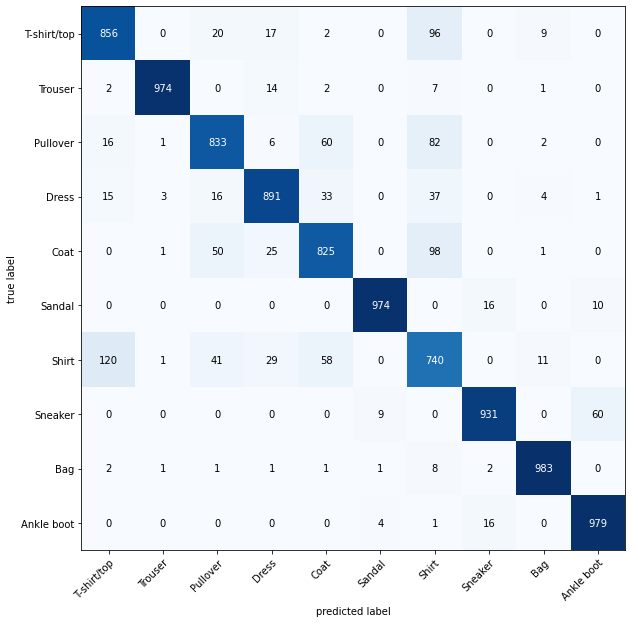

In [288]:
plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),class_names=test_data.classes,figsize=(10,10))

In [286]:
test_data.targets

tensor([9, 2, 1,  ..., 8, 1, 5])